### Development of a Personalized Comfort Index Function

#### The main goal of this project is to create a personalized comfort index model that calculates an individual's comfort level based on both external meteorological parameters (temperature, wind speed, humidity, UVA, AOD) and personal anthropometric data (age, gender, BMI derived from height and weight).

The analysis will be performed by building a regression model to achieve the following:

- Identify Dependencies: Determine how each external and personal factor influences the personalized comfort index.

- Incorporate BMI: Use Height and Weight to calculate the Body Mass Index (BMI) as a key personal feature.

- Extract Coefficients: Obtain the model coefficients that quantify the impact of each factor.

- Create a JSON Configuration

- Deliver to Backend Developers: Provide the final JSON file to backend developers. This will allow them to implement a function that calculates a unique comfort index for each user in real-time.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings


In [29]:
warnings.filterwarnings('ignore')

### Exploratory data analysis

In [30]:
df = pd.read_csv('synthetic_comfort_dataset_v2.csv')

In [31]:
df.shape

(2000, 17)

In [32]:
df.isnull().sum()

temperature            0
humidity               0
wind_speed             0
UVA                    0
AOD                    0
sex                    0
age                    0
height                 0
weight                 0
BMI                    0
comfort_temperature    0
comfort_humidity       0
comfort_wind           0
comfort_UVA            0
comfort_AOD            0
age_group              0
BMI_group              0
dtype: int64

In [33]:
df.head()

,temperature,humidity,wind_speed,UVA,AOD,sex,age,height,weight,BMI,comfort_temperature,comfort_humidity,comfort_wind,comfort_UVA,comfort_AOD,age_group,BMI_group
0,24.3,72.4,7.3,10.3,0.88,male,64,166.4,64.3,23.2,0.935,0.552,0.635,0.141667,0.02,senior,normal
1,20.9,85.7,1.4,1.8,0.46,female,29,135.3,78.2,42.7,0.895,0.086,0.930,0.750000,0.54,young,obese
2,29.2,23.8,1.9,3.3,0.31,male,79,174.1,58.7,19.4,0.490,0.476,0.905,0.725000,0.59,elderly,normal
3,37.0,20.9,3.6,1.1,0.61,male,25,156.7,51.3,20.9,0.300,0.418,0.820,0.908333,0.39,young,normal
4,14.9,66.3,12.9,2.5,0.19,male,38,164.5,41.7,15.4,0.695,0.674,0.155,0.791667,0.81,middle,underweight


In [34]:
df.describe().round(2)

,temperature,humidity,wind_speed,UVA,AOD,age,height,weight,BMI,comfort_temperature,comfort_humidity,comfort_wind,comfort_UVA,comfort_AOD
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,24.74,55.38,7.43,5.96,0.54,50.42,169.93,69.44,24.27,0.65,0.63,0.61,0.46,0.43
std,8.49,20.29,4.37,3.50,0.27,19.06,9.90,15.26,5.95,0.25,0.23,0.24,0.29,0.27
min,10.00,20.00,0.00,0.00,0.05,18.00,135.30,16.30,5.00,0.00,0.00,0.08,0.00,0.00
25%,17.60,37.80,3.60,2.90,0.31,34.00,163.20,59.20,20.18,0.47,0.45,0.40,0.19,0.20
50%,24.60,55.20,7.30,5.90,0.55,50.00,169.80,69.45,24.00,0.68,0.65,0.64,0.46,0.42
75%,31.90,73.20,11.30,9.10,0.76,66.00,176.90,79.60,28.20,0.87,0.82,0.82,0.71,0.65
max,40.00,90.00,15.00,12.00,1.00,84.00,200.60,118.60,44.80,1.00,1.00,1.00,1.00,0.95


### Visualization

In [35]:
comfort_metrics = ["comfort_temperature", "comfort_humidity", 
                   "comfort_wind", "comfort_UVA", "comfort_AOD"]

In [36]:
factors = ["sex", "age_group", "BMI_group"]

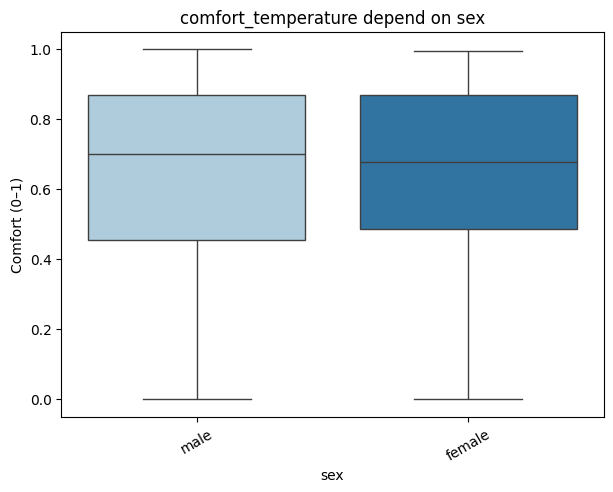

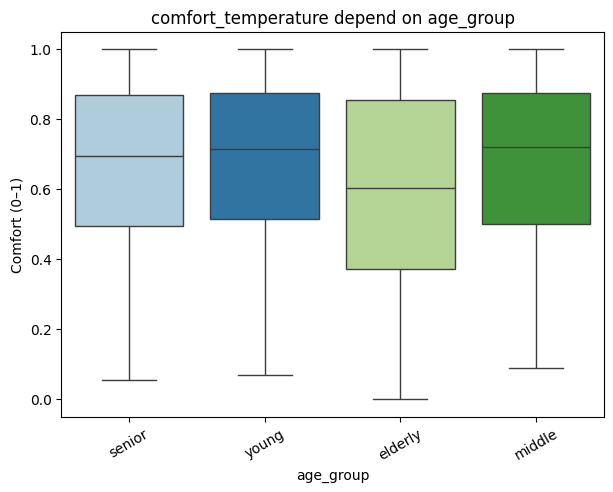

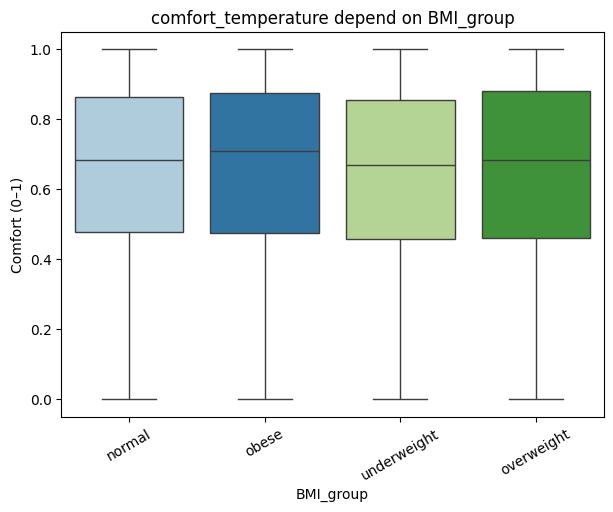

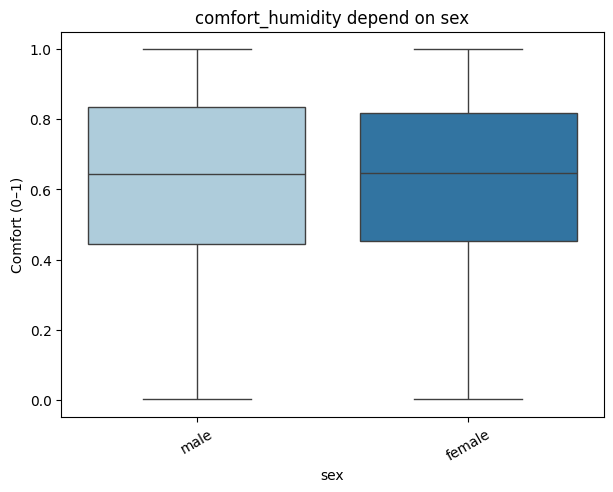

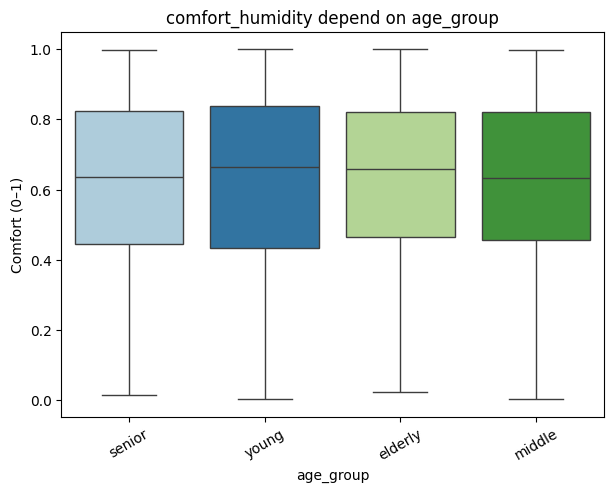

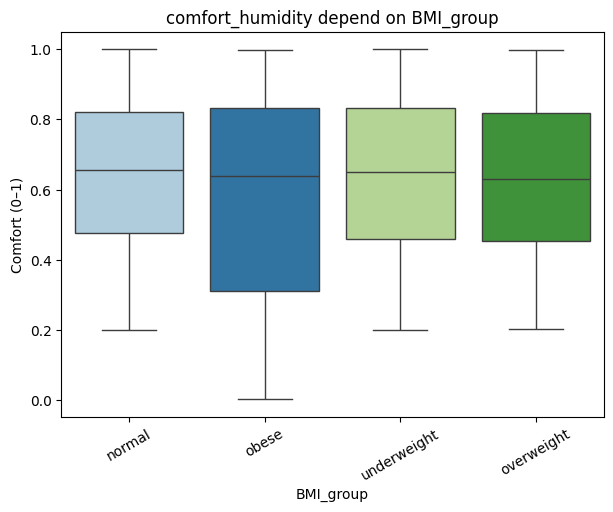

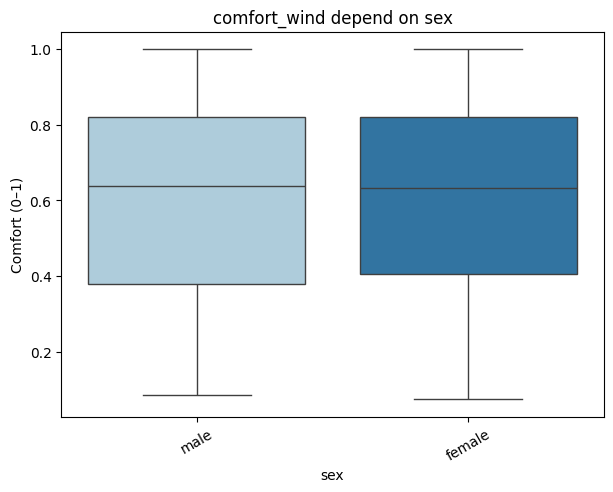

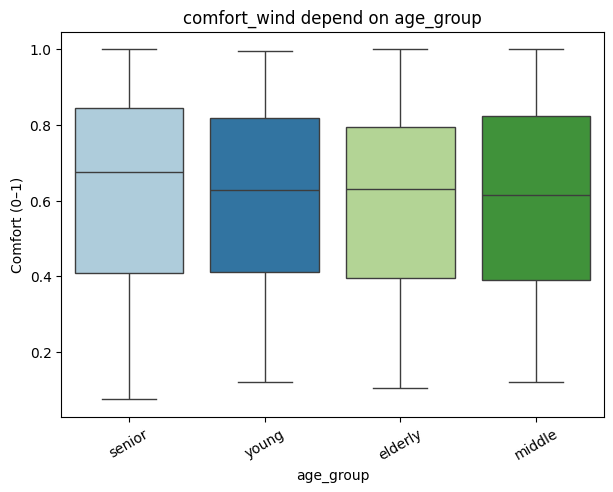

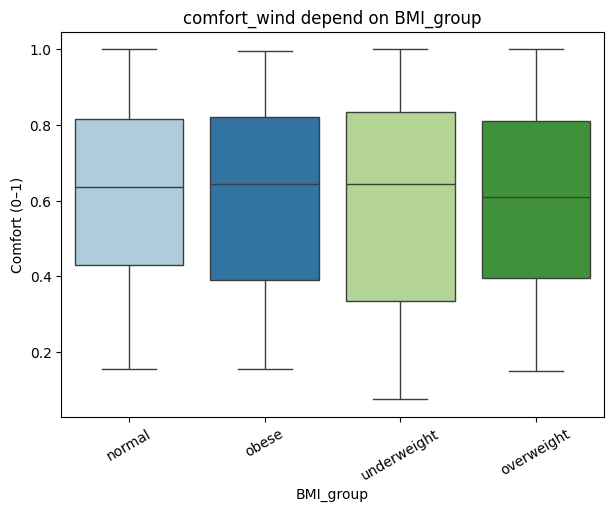

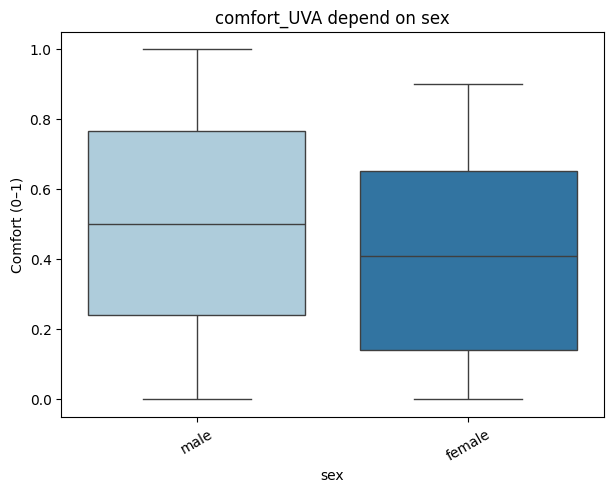

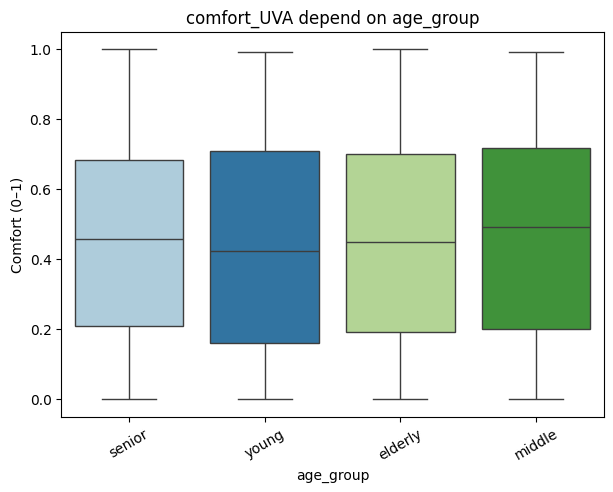

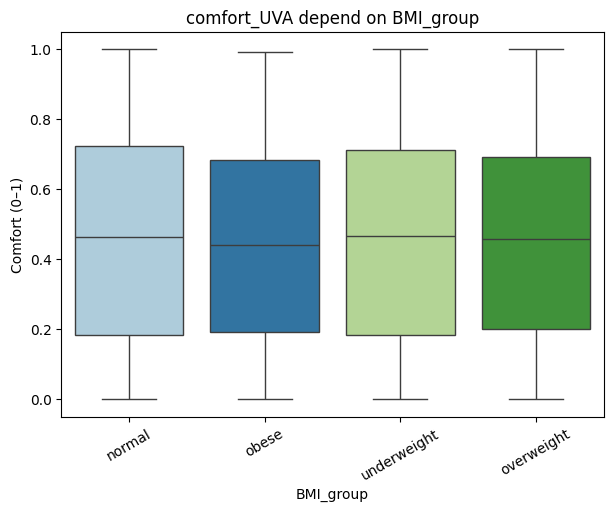

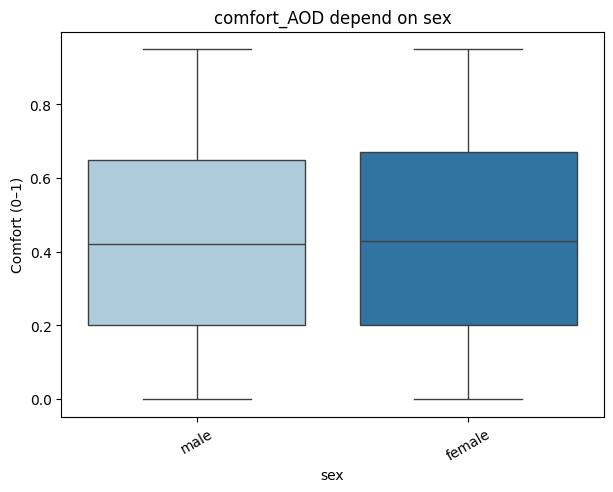

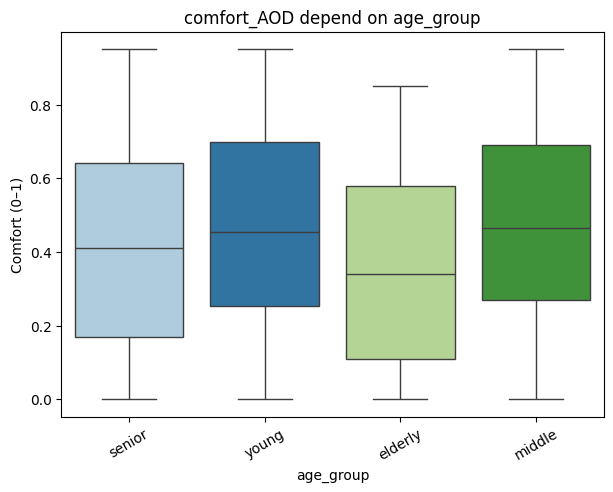

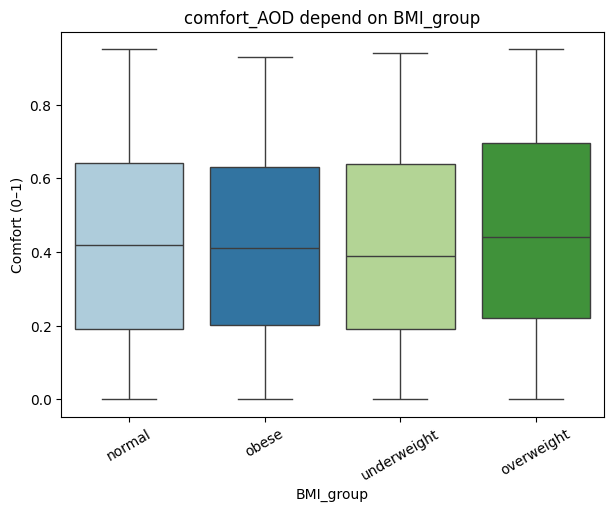

In [37]:
for cm in comfort_metrics:
    for factor in factors:
        plt.figure(figsize=(7,5))
        sns.boxplot(data=df, x=factor, y=cm, palette="Paired")
        plt.title(f"{cm} depend on {factor}")
        plt.xticks(rotation=30)
        plt.ylabel("Comfort (0–1)")
        plt.xlabel(factor)

        filename = f"images/{cm}_vs_{factor}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")

        plt.show() 

In [38]:
label_encoders = {}
df_encoded = df.copy()

In [39]:
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
print("Code sex: male=1, female=0")

Code sex: male=1, female=0


In [40]:
comfort_targets = ['comfort_temperature', 'comfort_humidity', 'comfort_wind', 'comfort_UVA', 'comfort_AOD']
environment_features = ['temperature', 'humidity', 'wind_speed', 'UVA', 'AOD']

#### Сorrelation

In [41]:
numeric_df = df[environment_features + comfort_targets]


In [42]:
correlation_matrix = numeric_df.corr()

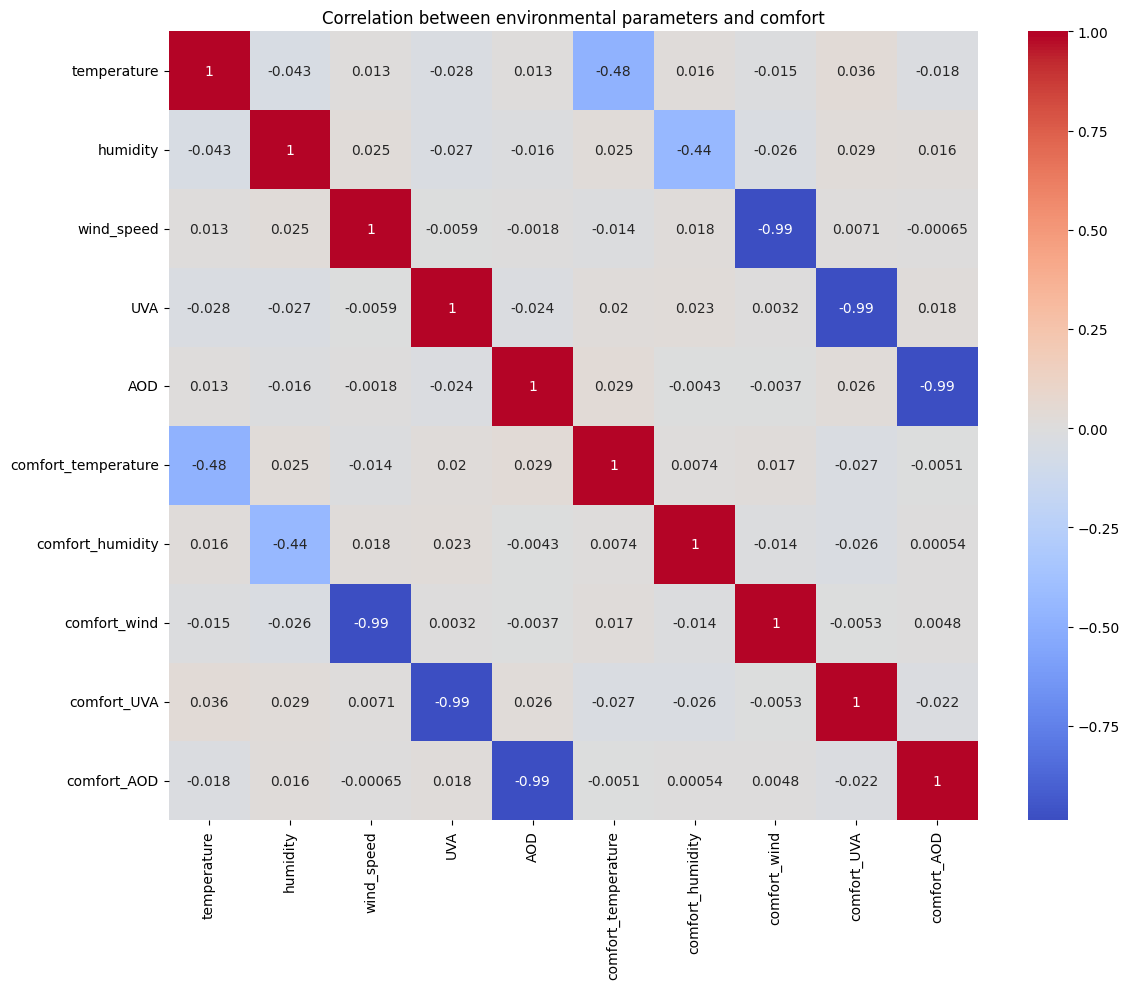

In [43]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between environmental parameters and comfort')
plt.tight_layout()

plt.savefig('images/correllation.png')
plt.show()

In [44]:
for target in comfort_targets:
    correlations = numeric_df.corr()[target].sort_values(ascending=False)
    print(f"\n{target}:")
    print(correlations.head(10))


comfort_temperature:
comfort_temperature    1.000000
AOD                    0.029369
humidity               0.025077
UVA                    0.020170
comfort_wind           0.016665
comfort_humidity       0.007417
comfort_AOD           -0.005062
wind_speed            -0.014332
comfort_UVA           -0.026619
temperature           -0.482504
Name: comfort_temperature, dtype: float64

comfort_humidity:
comfort_humidity       1.000000
UVA                    0.023487
wind_speed             0.017680
temperature            0.015563
comfort_temperature    0.007417
comfort_AOD            0.000538
AOD                   -0.004291
comfort_wind          -0.014230
comfort_UVA           -0.025540
humidity              -0.440328
Name: comfort_humidity, dtype: float64

comfort_wind:
comfort_wind           1.000000
comfort_temperature    0.016665
comfort_AOD            0.004832
UVA                    0.003180
AOD                   -0.003736
comfort_UVA           -0.005259
comfort_humidity      -0.014230

In [45]:
numeric_df = df.select_dtypes(include='number')

In [46]:
for target in comfort_targets:
    if target in numeric_df.columns:
        correlations = numeric_df.corr()[target].drop(target).sort_values(ascending=False)
        print(f"\n{target}:")
        print(correlations.head(10))
    else:
        print(f"\n{target} not found among numeric columns.")



comfort_temperature:
AOD                 0.029369
humidity            0.025077
UVA                 0.020170
comfort_wind        0.016665
height              0.011096
comfort_humidity    0.007417
weight              0.006665
BMI                 0.000283
comfort_AOD        -0.005062
wind_speed         -0.014332
Name: comfort_temperature, dtype: float64

comfort_humidity:
height                 0.025678
UVA                    0.023487
age                    0.018924
wind_speed             0.017680
temperature            0.015563
comfort_temperature    0.007417
comfort_AOD            0.000538
AOD                   -0.004291
comfort_wind          -0.014230
comfort_UVA           -0.025540
Name: comfort_humidity, dtype: float64

comfort_wind:
height                 0.062236
weight                 0.027879
comfort_temperature    0.016665
comfort_AOD            0.004832
UVA                    0.003180
age                    0.002412
AOD                   -0.003736
comfort_UVA           -0.0052

In [47]:
feature_columns = [
    'temperature', 'humidity', 'wind_speed', 'UVA', 'AOD',
    'sex', 'age', 'height', 'weight', 'BMI'
]

In [48]:
X = df_encoded[feature_columns]
results = {}


Analysis : comfort_temperature
Model accuracy:
MAE: 0.1918
R²: 0.3077

Importance of features (coefficients):
       Feature  Coefficient  Abs_Coefficient
0  temperature    -0.113674         0.113674
9          BMI    -0.064589         0.064589
8       weight     0.051113         0.051113
7       height    -0.029417         0.029417
6          age    -0.028075         0.028075
4          AOD     0.010385         0.010385
1     humidity     0.006831         0.006831
5          sex    -0.002946         0.002946
3          UVA     0.002198         0.002198
2   wind_speed    -0.001155         0.001155


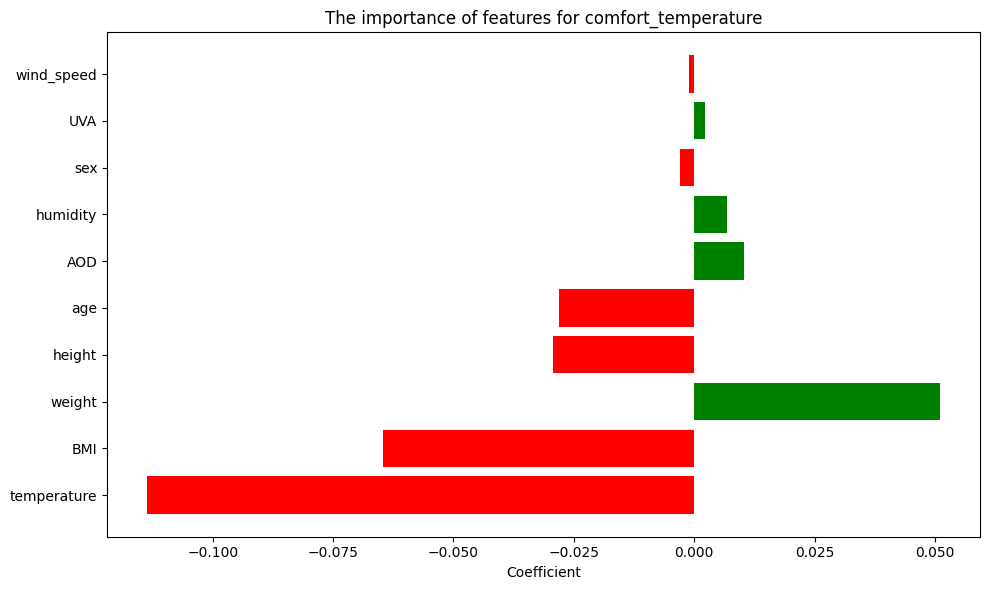

Analysis : comfort_humidity
Model accuracy:
MAE: 0.1775
R²: 0.2198

Importance of features (coefficients):
       Feature  Coefficient  Abs_Coefficient
9          BMI    -0.127599         0.127599
8       weight     0.097753         0.097753
1     humidity    -0.097257         0.097257
7       height    -0.052156         0.052156
0  temperature    -0.005279         0.005279
2   wind_speed     0.004332         0.004332
4          AOD    -0.002452         0.002452
3          UVA     0.001107         0.001107
6          age    -0.000399         0.000399
5          sex     0.000287         0.000287


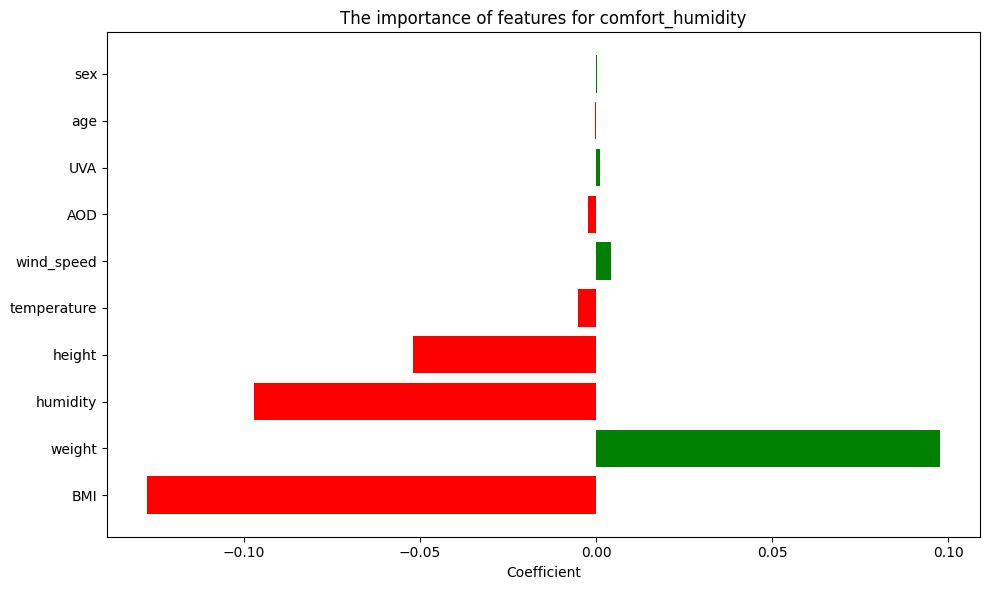

Analysis : comfort_wind
Model accuracy:
MAE: 0.0254
R²: 0.9832

Importance of features (coefficients):
       Feature  Coefficient  Abs_Coefficient
2   wind_speed    -0.239010         0.239010
8       weight     0.041076         0.041076
9          BMI    -0.037158         0.037158
7       height    -0.004744         0.004744
4          AOD    -0.001607         0.001607
5          sex    -0.001358         0.001358
6          age     0.001223         0.001223
1     humidity    -0.000983         0.000983
3          UVA    -0.000655         0.000655
0  temperature    -0.000202         0.000202


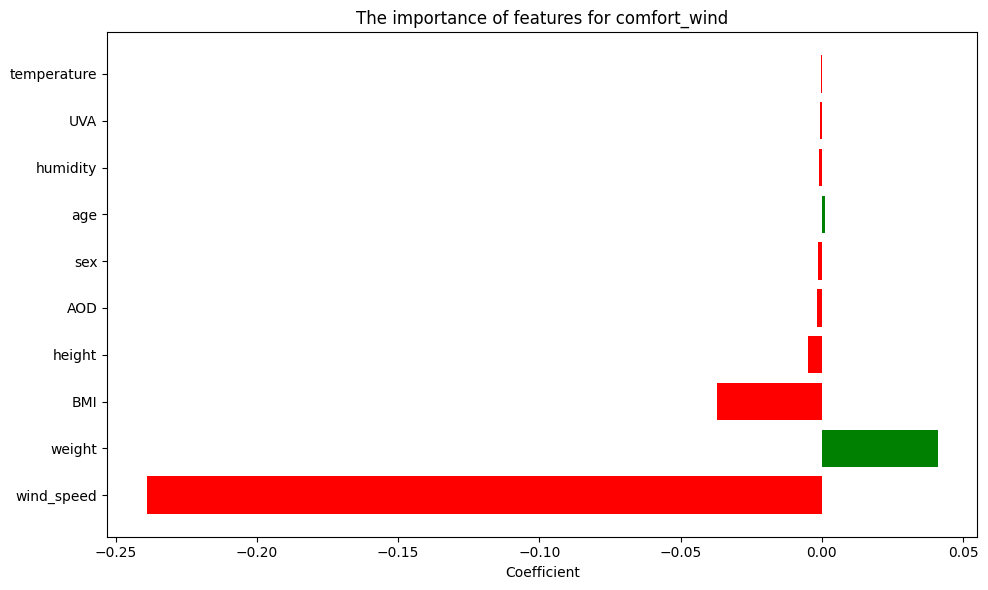

Analysis : comfort_UVA
Model accuracy:
MAE: 0.0058
R²: 0.9980

Importance of features (coefficients):
       Feature  Coefficient  Abs_Coefficient
3          UVA    -0.289377         0.289377
5          sex     0.047674         0.047674
9          BMI     0.002149         0.002149
8       weight    -0.001603         0.001603
7       height     0.000622         0.000622
1     humidity     0.000452         0.000452
0  temperature     0.000306         0.000306
4          AOD     0.000268         0.000268
6          age     0.000190         0.000190
2   wind_speed    -0.000119         0.000119


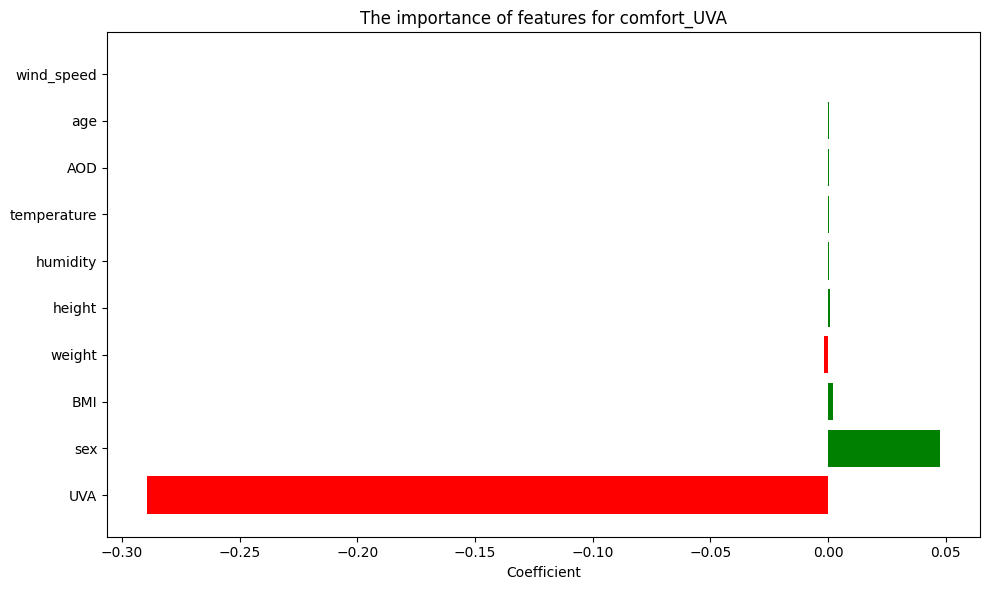

Analysis : comfort_AOD
Model accuracy:
MAE: 0.0219
R²: 0.9904

Importance of features (coefficients):
       Feature  Coefficient  Abs_Coefficient
4          AOD    -0.266658         0.266658
6          age    -0.037238         0.037238
9          BMI     0.005096         0.005096
8       weight    -0.004346         0.004346
7       height     0.002514         0.002514
1     humidity    -0.000932         0.000932
2   wind_speed    -0.000755         0.000755
3          UVA    -0.000649         0.000649
0  temperature     0.000438         0.000438
5          sex    -0.000006         0.000006


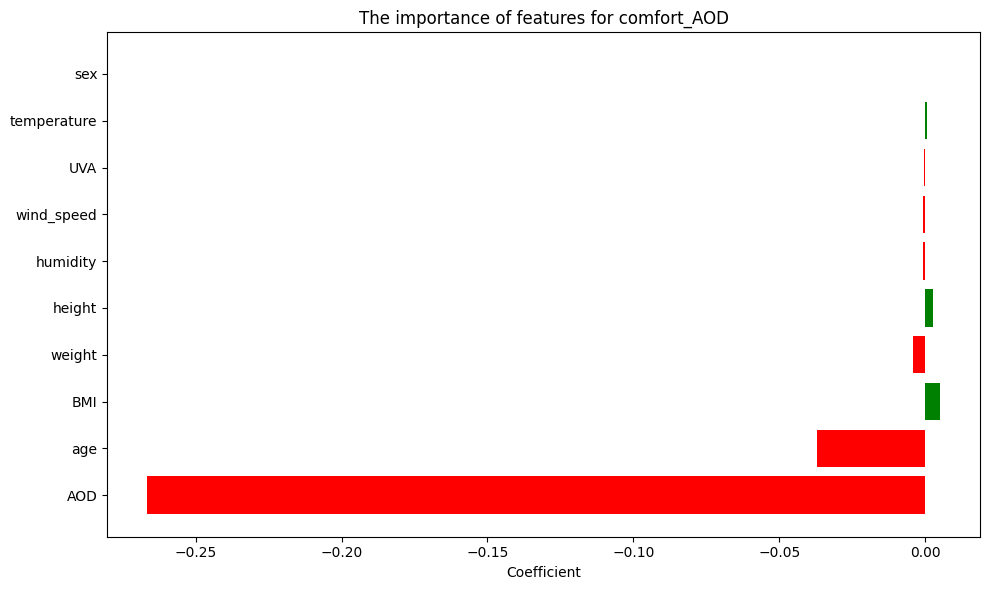

In [49]:
for i, target in enumerate(comfort_targets):
    print(f"Analysis : {target}")
    
    y = df_encoded[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # train
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model accuracy:")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    results[target] = {
        'model': model,
        'scaler': scaler,
        'mae': mae,
        'r2': r2,
        'feature_importance': dict(zip(feature_columns, model.coef_))
    }
    
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nImportance of features (coefficients):")
    print(importance_df)
    
    #visual of importance
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in importance_df['Coefficient']]
    plt.barh(importance_df['Feature'], importance_df['Coefficient'], color=colors)
    plt.xlabel('Coefficient')
    plt.title(f'The importance of features for {target}')
    plt.tight_layout()
    filename = f"images/importance_{target}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")

    plt.show()

### Formulas

In [50]:
formulas = {}

for target in comfort_targets:
    model = results[target]['model']
    scaler = results[target]['scaler']
    
    intercept = model.intercept_
    coefficients = model.coef_
    
    formula_parts = [f"{intercept:.6f}"]
    
    for i, feature in enumerate(feature_columns):
        if abs(coefficients[i]) > 0.0001:
            sign = "+" if coefficients[i] >= 0 else "-"
            formula_parts.append(f"{sign} {abs(coefficients[i]):.6f}*{feature}_norm")
    
    formula = " ".join(formula_parts)
    
    formulas[target] = {
        'formula': formula,
        'intercept': intercept,
        'coefficients': dict(zip(feature_columns, coefficients)),
        'scaling_params': {
            feature: {'mean': scaler.mean_[i], 'std': scaler.scale_[i]} 
            for i, feature in enumerate(feature_columns)
        }
    }
    
    print(f"\n {target}:")
    print(f"Formula: comfort = {formula}")
    print(f"where:")
    for feature in feature_columns:
        print(f"  {feature}_norm = ({feature} - {scaler.mean_[feature_columns.index(feature)]:.2f}) / {scaler.scale_[feature_columns.index(feature)]:.2f}")



 comfort_temperature:
Formula: comfort = 0.648906 - 0.113674*temperature_norm + 0.006831*humidity_norm - 0.001155*wind_speed_norm + 0.002198*UVA_norm + 0.010385*AOD_norm - 0.002946*sex_norm - 0.028075*age_norm - 0.029417*height_norm + 0.051113*weight_norm - 0.064589*BMI_norm
where:
  temperature_norm = (temperature - 24.65) / 8.47
  humidity_norm = (humidity - 54.65) / 20.13
  wind_speed_norm = (wind_speed - 7.48) / 4.37
  UVA_norm = (UVA - 5.98) / 3.52
  AOD_norm = (AOD - 0.54) / 0.27
  sex_norm = (sex - 0.51) / 0.50
  age_norm = (age - 50.49) / 19.06
  height_norm = (height - 170.02) / 9.86
  weight_norm = (weight - 69.79) / 15.10
  BMI_norm = (BMI - 24.38) / 5.93

 comfort_humidity:
Formula: comfort = 0.636105 - 0.005279*temperature_norm - 0.097257*humidity_norm + 0.004332*wind_speed_norm + 0.001107*UVA_norm - 0.002452*AOD_norm + 0.000287*sex_norm - 0.000399*age_norm - 0.052156*height_norm + 0.097753*weight_norm - 0.127599*BMI_norm
where:
  temperature_norm = (temperature - 24.65) 

In [51]:
coefficients_df = pd.DataFrame({
    'Feature': feature_columns,
    **{target: results[target]['feature_importance'][feature] 
       for target in comfort_targets for feature in feature_columns}
})
coefficients_data = []
for feature in feature_columns:
    row = {'Feature': feature}
    for target in comfort_targets:
        row[target] = results[target]['feature_importance'][feature]
    coefficients_data.append(row)
coefficients_df = pd.DataFrame(coefficients_data)
print(coefficients_df.round(6))

       Feature  comfort_temperature  comfort_humidity  comfort_wind  \
0  temperature            -0.113674         -0.005279     -0.000202   
1     humidity             0.006831         -0.097257     -0.000983   
2   wind_speed            -0.001155          0.004332     -0.239010   
3          UVA             0.002198          0.001107     -0.000655   
4          AOD             0.010385         -0.002452     -0.001607   
5          sex            -0.002946          0.000287     -0.001358   
6          age            -0.028075         -0.000399      0.001223   
7       height            -0.029417         -0.052156     -0.004744   
8       weight             0.051113          0.097753      0.041076   
9          BMI            -0.064589         -0.127599     -0.037158   

   comfort_UVA  comfort_AOD  
0     0.000306     0.000438  
1     0.000452    -0.000932  
2    -0.000119    -0.000755  
3    -0.289377    -0.000649  
4     0.000268    -0.266658  
5     0.047674    -0.000006  
6     0.

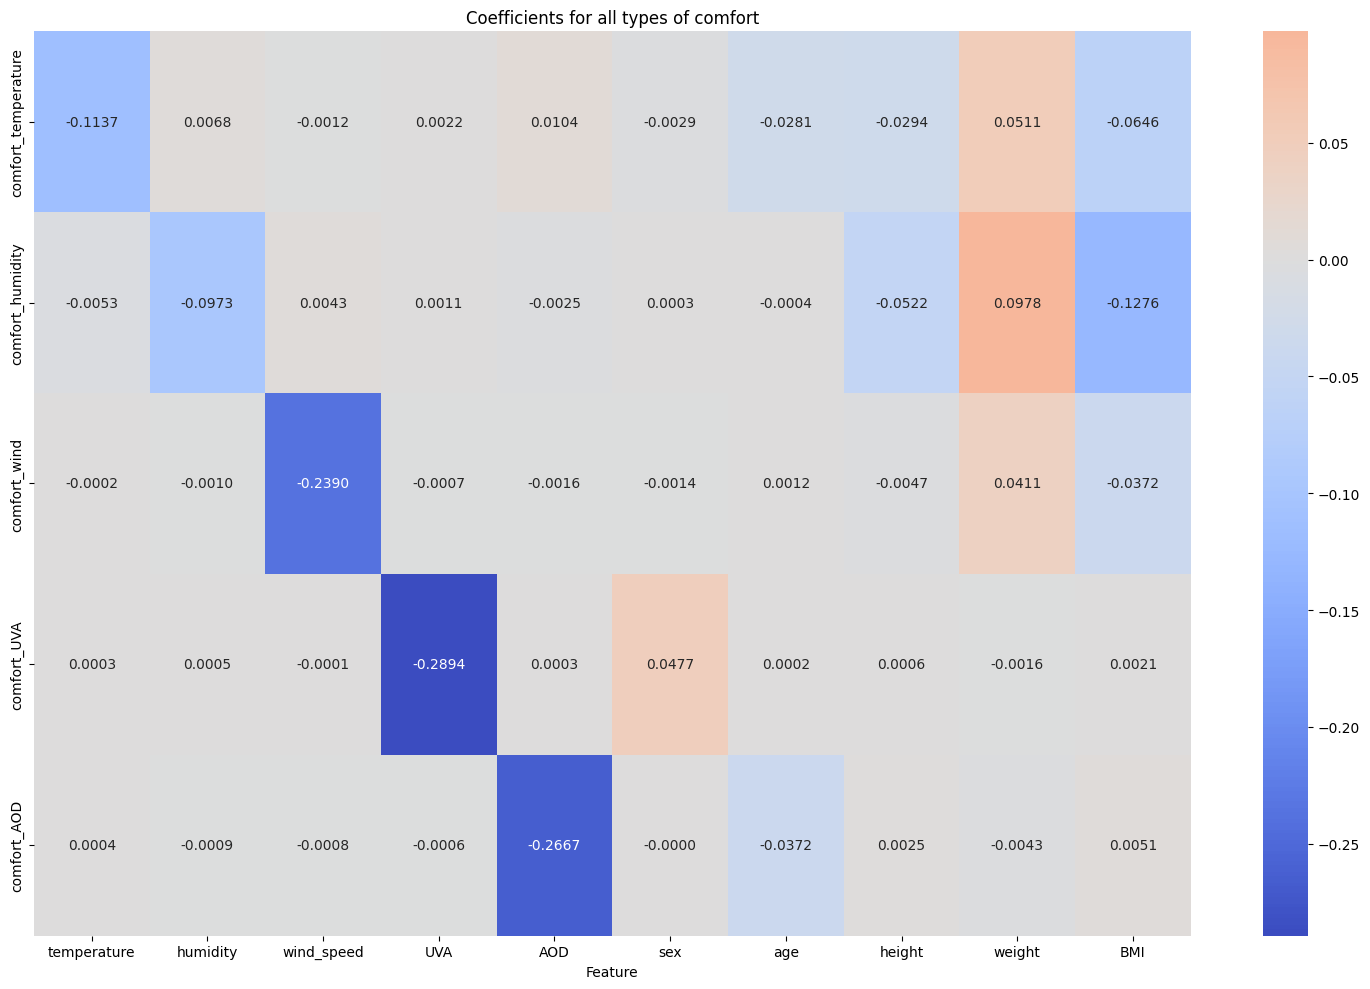

In [52]:
plt.figure(figsize=(15, 10))
heatmap_data = coefficients_df.set_index('Feature').T
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0, fmt='.4f')
plt.title('Coefficients for all types of comfort')
plt.tight_layout()
plt.show()

In [53]:
quality_df = pd.DataFrame({
    'Target': comfort_targets,
    'MAE': [results[target]['mae'] for target in comfort_targets],
    'R²': [results[target]['r2'] for target in comfort_targets]
})

In [54]:
print(quality_df.round(4))

                Target     MAE      R²
0  comfort_temperature  0.1918  0.3077
1     comfort_humidity  0.1775  0.2198
2         comfort_wind  0.0254  0.9832
3          comfort_UVA  0.0058  0.9980
4          comfort_AOD  0.0219  0.9904


### What was done

- Conducted correlation analysis for all comfort indicators.

- Constructed linear regressions for each of them (temperature, humidity, wind, UVA, AOD).

- Evaluated models by MAE and R².

- Deduced the importance coefficients of the features and formed formulas.

- Constructed summary tables and heat maps of the coefficients.

##### Temperature comfort (comfort_temperature)

Comfort is most reduced by: BMI (-0.0646), height (-0.0294), age (-0.0281).

Comfort is increased by: weight (0.0511).
So, temperature is perceived differently by people depending on physiological parameters.

##### Humidity comfort (comfort_humidity)

The greatest negative impact: BMI (-0.1276) and height (-0.0522).

Positive impact: weight (0.0978).
Humidity is less comfortable for people with a higher BMI, and more comfortable for those with a higher weight.

##### Wind comfort (comfort_wind)

Strong negative impact: wind speed (-0.2390) - obviously, more wind = less comfort.

Other factors have a weaker impact.

##### UVA comfort (comfort_UVA)

Mostly reduces comfort: UVA (-0.2894) → high levels of UVA reduce comfort.

Slightly increases: gender (0.0477) → men/women may have different perceptions.

AOD comfort (comfort_AOD) (aerosol particles in the air)

Strongly negative impact: AOD (-0.2667) → the more pollution, the lower the comfort.

Age also has a negative impact (-0.0372) → older people tolerate polluted air worse.

## RESULTS
- Personalization: The same weather conditions give different comfort ratings depending on physiology (BMI, weight, height, age). This makes the model useful for personalized recommendations (e.g. HVAC, gyms, outdoor apps).

- Key environmental metrics: for each comfort dimension there is "its" most important factor: temperature → comfort_temperature; humidity → comfort_humidity; wind_speed → comfort_wind; UVA → comfort_UVA; AOD → comfort_AOD. "each comfort dimension has its main environmental driver".

- Cautions: the model is linear - it does not capture possible nonlinearities and interactions (e.g. the effect of temperature may depend on humidity). I recommend further testing tree models or SHAP for interactions.

## RESULTS
- Personalization: The same weather conditions give different comfort ratings depending on physiology (BMI, weight, height, age). This makes the model useful for personalized recommendations (e.g. HVAC, gyms, outdoor apps).

- Key environmental metrics: for each comfort dimension there is "its" most important factor: temperature → comfort_temperature; humidity → comfort_humidity; wind_speed → comfort_wind; UVA → comfort_UVA; AOD → comfort_AOD. "each comfort dimension has its main environmental driver".

- Cautions: the model is linear - it does not capture possible nonlinearities and interactions (e.g. the effect of temperature may depend on humidity). I recommend further testing tree models or SHAP for interactions.

#### Correlations

Direct relationships are weak (all coefficients ≤0.06).

The strongest (but still weak) relationships are:

comfort_wind ↔ height (0.06),

comfort_temperature ↔ AOD (0.03),

comfort_UVA ↔ temperature (0.036).
→ This means that comfort cannot be explained by any one factor — the impact is complex.

The main conclusion:

Human comfort depends on gender, age and BMI, but the effect is weak and only manifests itself in certain conditions (e.g. cold/heat, wind).


In [55]:
import json

backend_config = {
    "model_type": "linear_regression",
    "feature_columns": feature_columns,
    "formulas": formulas,
    "overall_accuracy": {
        "average_mae": quality_df['MAE'].mean(),
        "average_r2": quality_df['R²'].mean()
    }
}

print(json.dumps(backend_config, indent=2, ensure_ascii=False, default=str))



# Example
test_example = {
    'temperature': 25.0,
    'humidity': 60.0,
    'wind_speed': 5.0,
    'UVA': 3.0,
    'AOD': 0.3,
    'sex': 1,  # male
    'age': 35,
    'height': 175,
    'weight': 70,
    'BMI': 22.86
}

print("TEST:")
for key, value in test_example.items():
    print(f"  {key}: {value}")

print("\nComfort calculation:")

def calculate_comfort(features, formulas_config):
    """Function for calculating comfort"""
    results = {}
    
    for target, formula_data in formulas_config['formulas'].items():
        
        normalized_features = {}
        for feature in feature_columns:
            mean = formula_data['scaling_params'][feature]['mean']
            std = formula_data['scaling_params'][feature]['std']
            normalized_features[feature] = (features[feature] - mean) / std
        
        comfort = formula_data['intercept']
        for feature, coef in formula_data['coefficients'].items():
            comfort += coef * normalized_features[feature]
        
        results[target] = max(0, min(1, comfort))
    
    return results

comfort_results = calculate_comfort(test_example, backend_config)

for comfort_type, value in comfort_results.items():
    print(f"  {comfort_type}: {value:.4f} ({value*100:.1f}%)")



print("\n PATTERNS FOUND:")
print("1. Temperature: has the greatest impact on temperature comfort")
print("2. Humidity: key factor for humidity comfort")
print("3. Wind: wind speed has the greatest impact on wind comfort")
print("4. UVA and AOD: less significant, but still important")
print("5. Gender, age, weight, height: have a moderate impact")

print("\n BACKEND RECOMMENDATIONS:")
print("1. Use the formulas provided for calculation")
print("2. Be sure to normalize the input data")
print("3. Limit the results between 0 and 1")
print("4. The most important parameters: temperature, humidity, wind speed")



{
  "model_type": "linear_regression",
  "feature_columns": [
    "temperature",
    "humidity",
    "wind_speed",
    "UVA",
    "AOD",
    "sex",
    "age",
    "height",
    "weight",
    "BMI"
  ],
  "formulas": {
    "comfort_temperature": {
      "formula": "0.648906 - 0.113674*temperature_norm + 0.006831*humidity_norm - 0.001155*wind_speed_norm + 0.002198*UVA_norm + 0.010385*AOD_norm - 0.002946*sex_norm - 0.028075*age_norm - 0.029417*height_norm + 0.051113*weight_norm - 0.064589*BMI_norm",
      "intercept": 0.64890625,
      "coefficients": {
        "temperature": -0.11367436633987044,
        "humidity": 0.006830875370136106,
        "wind_speed": -0.0011550603826913342,
        "UVA": 0.002197828133733751,
        "AOD": 0.010385436939777849,
        "sex": -0.0029460928387348316,
        "age": -0.028074665059557878,
        "height": -0.029416961346821667,
        "weight": 0.05111331370943813,
        "BMI": -0.06458948351111614
      },
      "scaling_params": {
        